# Hierarchical Gaussian Filter

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/RxInfer.jl/examples`


In this demo the goal is to perform approximate variational Bayesian Inference for Univariate Hierarchical Gaussian Filter (HGF).

Simple HGF model can be defined as:

$$\begin{aligned}
  x^{(j)}_k & \sim \, \mathcal{N}(x^{(j)}_{k - 1}, f_k(x^{(j - 1)}_k)) \\
  y_k & \sim \, \mathcal{N}(x^{(j)}_k, \tau_k)
\end{aligned}$$

where $j$ is an index of layer in hierarchy, $k$ is a time step and $f_k$ is a variance activation function. `RxInfer.jl` export Gaussian Controlled Variance (GCV) node with $f_k = \exp(\kappa x + \omega)$ variance activation function. By default the node uses Gauss-Hermite cubature with a prespecified number of approximation points in the cubature. In this demo we also show how we can change the hyperparameters in different approximation methods (iin this case Gauss-Hermite cubature) with the help of metadata structures. Here how our model will look like with the GCV node:

$$\begin{aligned}
  z_k & \sim \, \mathcal{N}(z_{k - 1}, \mathcal{\tau_z}) \\
  x_k & \sim \, \mathcal{N}(x_{k - 1}, \exp(\kappa z_k + \omega)) \\
  y_k & \sim \, \mathcal{N}(x_k, \mathcal{\tau_y})
\end{aligned}$$

In this experiment we will create a single time step of the graph and perform variational message passing filtering alrogithm to estimate hidden states of the system. For a more rigorous introduction to Hierarchical Gaussian Filter we refer to [Ismail Senoz, Online Message Passing-based Inference in the Hierarchical Gaussian Filter](https://ieeexplore.ieee.org/document/9173980) paper.

For simplicity we will consider $\tau_z$, $\tau_y$, $\kappa$ and $\omega$ known and fixed, but there are no principled limitations to make them random variables too.

To model this process in `RxInfer`, first, we start with importing all needed packages:

In [2]:
using RxInfer, BenchmarkTools, Random, Plots, StableRNGs

Next step, is to generate some synthetic data:

In [5]:
function generate_data(rng, n, k, w, zv, yv)
    z_prev = 0.0
    x_prev = 0.0

    z = Vector{Float64}(undef, n)
    v = Vector{Float64}(undef, n)
    x = Vector{Float64}(undef, n)
    y = Vector{Float64}(undef, n)

    for i in 1:n
        z[i] = rand(rng, Normal(z_prev, sqrt(zv)))
        v[i] = exp(k * z[i] + w)
        x[i] = rand(rng, Normal(x_prev, sqrt(v[i])))
        y[i] = rand(rng, Normal(x[i], sqrt(yv)))

        z_prev = z[i]
        x_prev = x[i]
    end 
    
    return z, x, y
end

generate_data (generic function with 1 method)

In [6]:
# Seed for reproducibility
seed = 42

rng = StableRNG(seed)

# Parameters of HGF process
real_k = 1.0
real_w = 0.0
z_variance = abs2(0.2)
y_variance = abs2(0.1)

# Number of observations
n = 300

z, x, y = generate_data(rng, n, real_k, real_w, z_variance, y_variance);

Let's plot our synthetic dataset. Lines represent our hidden states we want to estimate using noisy observations.

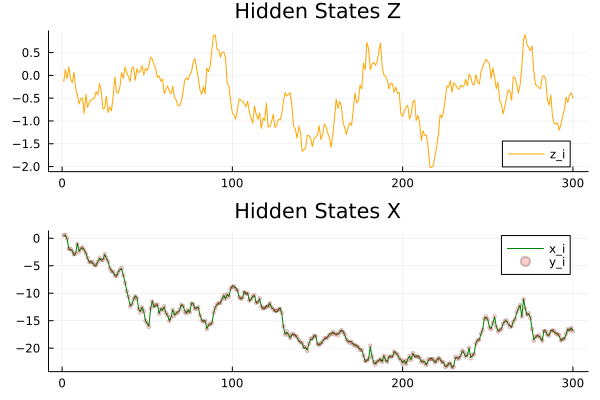

In [7]:
let 
    pz = plot(title = "Hidden States Z")
    px = plot(title = "Hidden States X")
    
    plot!(pz, 1:n, z, label = "z_i", color = :orange)
    plot!(px, 1:n, x, label = "x_i", color = :green)
    scatter!(px, 1:n, y, label = "y_i", color = :red, ms = 2, alpha = 0.2)
    
    plot(pz, px, layout = @layout([ a; b ]))
end

## Online learning (Filtering)

To create a model we use the `@model` macro:

In [8]:
# We create a single-time step of corresponding state-space process to
# perform online learning (filtering)
@model function hgf(y, κ, ω, z_variance, y_variance, z_prev_mean, z_prev_var, x_prev_mean, x_prev_var)

    z_prev ~ Normal(mean = z_prev_mean, variance = z_prev_var)
    x_prev ~ Normal(mean = x_prev_mean, variance = x_prev_var)

    # Higher layer is modelled as a random walk 
    z_next ~ Normal(mean = z_prev, variance = z_variance)
    
    # Lower layer is modelled with `GCV` node
    x_next ~ GCV(x_prev, z_next, κ, ω)
    
    # Noisy observations 
    y ~ Normal(mean = x_next, variance = y_variance)
end

@constraints function hgfconstraints() 
    # Mean-field factorization constraints
    q(x_next, x_prev, z_next) = q(x_next)q(x_prev)q(z_next)
end

@meta function hgfmeta()
    # Lets use 31 approximation points in the Gauss Hermite cubature approximation method
    GCV() -> GCVMetadata(GaussHermiteCubature(31)) 
end

hgfmeta (generic function with 1 method)

The code below uses the `infer` function from `RxInfer` to generate the message passing algorithm given the model and constraints specification. 
We also specify the `@autoupdates` in order to set new priors for the next observation based on posteriors.

In [9]:
function run_inference(data, real_k, real_w, z_variance, y_variance)

    autoupdates   = @autoupdates begin
        # The posterior becomes the prior for the next time step
        z_prev_mean, z_prev_var = mean_var(q(z_next))
        x_prev_mean, x_prev_var = mean_var(q(x_next))
    end

    init = @initialization begin
        q(x_next) = NormalMeanVariance(0.0, 5.0)
        q(z_next) = NormalMeanVariance(0.0, 5.0)
    end

    return infer(
        model          = hgf(κ = real_k, ω = real_w, z_variance = z_variance, y_variance = y_variance),
        constraints    = hgfconstraints(),
        meta           = hgfmeta(),
        data           = (y = data, ),
        autoupdates    = autoupdates,
        keephistory    = length(data),
        historyvars    = (
            x_next = KeepLast(),
            z_next = KeepLast()
        ),
        initialization = init,
        iterations     = 5,
        free_energy    = true,
    )
end

run_inference (generic function with 1 method)

Everything is ready to run the algorithm. We used the online version of the algorithm, thus we need to fetch the history of the posterior estimation instead of the actual posteriors.

In [10]:
result = run_inference(y, real_k, real_w, z_variance, y_variance);

mz = result.history[:z_next];
mx = result.history[:x_next];

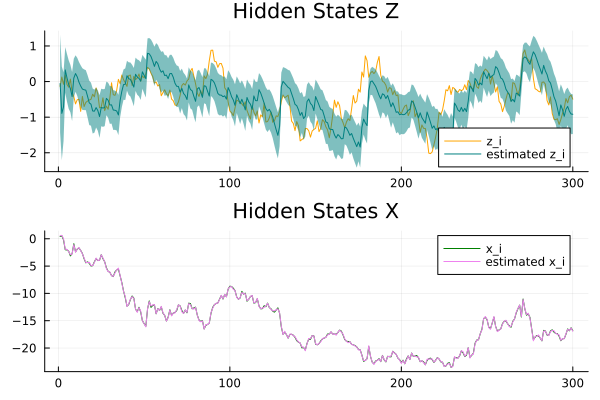

In [11]:
let 
    pz = plot(title = "Hidden States Z")
    px = plot(title = "Hidden States X")
    
    plot!(pz, 1:n, z, label = "z_i", color = :orange)
    plot!(pz, 1:n, mean.(mz), ribbon = std.(mz), label = "estimated z_i", color = :teal)
    
    plot!(px, 1:n, x, label = "x_i", color = :green)
    plot!(px, 1:n, mean.(mx), ribbon = std.(mx), label = "estimated x_i", color = :violet)
    
    plot(pz, px, layout = @layout([ a; b ]))
end

As we can see from our plot, estimated signal resembles closely to the real hidden states with small variance. We maybe also interested in the values for Bethe Free Energy functional:

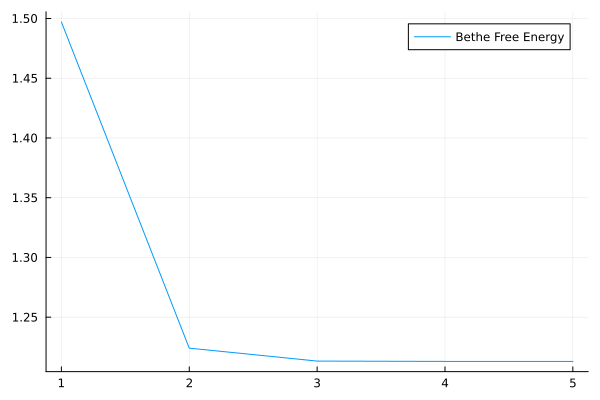

In [12]:
plot(result.free_energy_history, label = "Bethe Free Energy")

As we can see BetheFreeEnergy converges nicely to a stable point. 

## Offline learning (Smoothing)

Aside from online learning, we can also perform offline learning (smoothing) with the HGF model to learn the parameters in case we have collected all the data. In this offline setting, we treat the parameters $\kappa$ and $\omega$ as random variables and place a prior over them. These parameters will be updated along with latent states during the inference. First, let's define the HGF model for offline learning

In [76]:
#Model for offline learning (smoothing)

@model function hgf_smoothing(y, z_variance, y_variance)
    # Initial states 
    z_prev ~ Normal(mean = 0., variance = 5.0)
    x_prev ~ Normal(mean = 0., variance = 5.0)

    # Priors on κ and ω
    κ ~ Normal(mean = 1.5, variance = 1.0)
    ω ~ Normal(mean = 0.0, variance = 0.05)

    for i in eachindex(y)
        # Higher layer 
        z[i] ~ Normal(mean = z_prev, variance = z_variance)

        # Lower layer 
        x[i] ~ GCV(x_prev, z[i], κ, ω)

        # Noisy observations 
        y[i] ~ Normal(mean = x[i], variance = y_variance)

        # Update last/previous hidden states
        z_prev = z[i]
        x_prev = x[i]
    end
end

@constraints function hgfconstraints_smoothing() 
    #Structured mean-field factorization constraints
    q(x_prev,x, z,κ,ω) = q(x_prev,x)q(z)q(κ)q(ω)
end

@meta function hgfmeta_smoothing()
    # Lets use 31 approximation points in the Gauss Hermite cubature approximation method
    GCV() -> GCVMetadata(GaussHermiteCubature(31)) 
end

hgfmeta_smoothing (generic function with 1 method)

Similar to the filtering case, we use the `infer` function from `RxInfer` to implement inference. 

In [77]:
function run_inference_smoothing(data, z_variance, y_variance)
    @initialization function hgf_init_smoothing()
        q(x) = NormalMeanVariance(0.0,5.0)
        q(z) = NormalMeanVariance(0.0,5.0)
        q(κ) = NormalMeanVariance(1.5,1.0)
        q(ω) = NormalMeanVariance(0.0,0.05)
    end

    #Let's do inference with 20 iterations 
    return infer(
        model = hgf_smoothing(z_variance = z_variance, y_variance = y_variance,),
        data = (y = data,),
        meta = hgfmeta_smoothing(),
        constraints = hgfconstraints_smoothing(),
        initialization = hgf_init_smoothing(),
        iterations = 20,
        returnvars = (x = KeepLast(), z = KeepLast(),ω=KeepLast(),κ=KeepLast(),),
        free_energy = true 
    )
end

run_inference_smoothing (generic function with 1 method)

Now we can get the result.

In [78]:
result_smoothing = run_inference_smoothing(y, z_variance, y_variance);
mz_smoothing = result_smoothing.posteriors[:z];
mx_smoothing = result_smoothing.posteriors[:x];

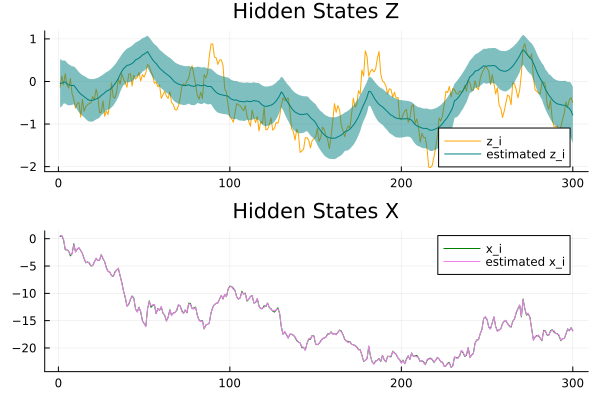

In [79]:
let 
    pz = plot(title = "Hidden States Z")
    px = plot(title = "Hidden States X")
    
    plot!(pz, 1:n, z, label = "z_i", color = :orange)
    plot!(pz, 1:n, mean.(mz_smoothing), ribbon = std.(mz_smoothing), label = "estimated z_i", color = :teal)
    
    plot!(px, 1:n, x, label = "x_i", color = :green)
    plot!(px, 1:n, mean.(mx_smoothing), ribbon = std.(mx_smoothing), label = "estimated x_i", color = :violet)
    
    plot(pz, px, layout = @layout([ a; b ]))
end

As we can see from our plot, estimated signal resembles to the real hidden states and appears "smoother" compared to the filtering case. We may be also interested in the values for Bethe Free Energy functional:

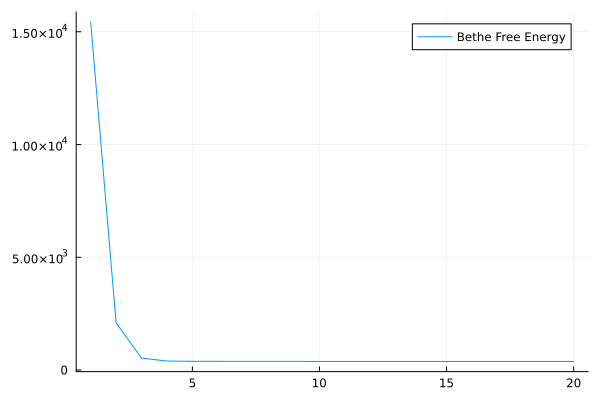

In [80]:
plot(result_smoothing.free_energy, label = "Bethe Free Energy")

Finally, we can also extract the marginals $q(\kappa)$ and $q(\omega)$ to get the appropximation of these parameters.

In [81]:
q_κ = result_smoothing.posteriors[:κ]
q_ω = result_smoothing.posteriors[:ω]

println("Approximate value of κ: ", mean(q_κ))
println("Approximate value of ω: ", mean(q_ω))

Approximate value of κ: 0.754338657989883
Approximate value of ω: -0.1816489286662659


Let's visualize their marginal distributions.

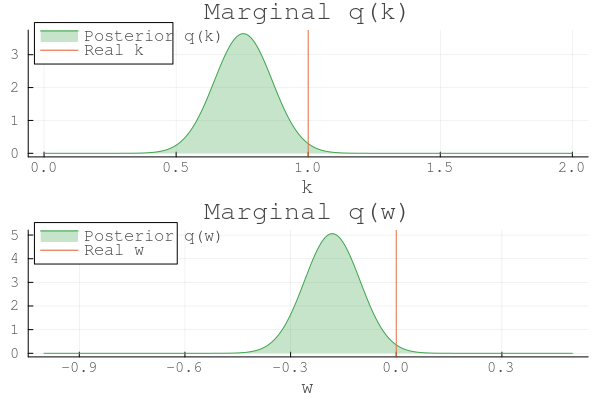

In [82]:
range_w = range(-1,0.5,length = 1000)
range_k = range(0,2,length = 1000)
let 
    pw = plot(title = "Marginal q(w)")
    pk = plot(title = "Marginal q(k)")
    
    plot!(pw, range_w, (x) -> pdf(q_ω, x), fillalpha=0.3, fillrange = 0, label="Posterior q(w)", c=3, legend_position=(0.1,0.95), fontfamily="monospace",legendfontsize=9)
    vline!([real_w], label="Real w")
    xlabel!("w")
    
    
    plot!(pk, range_k, (x) -> pdf(q_κ, x), fillalpha=0.3, fillrange = 0, label="Posterior q(k)", c=3, legend_position=(0.1,0.95), fontfamily="monospace",legendfontsize=9)
    vline!([real_k], label="Real k")
    xlabel!("k")
    
    plot(pk, pw, layout = @layout([ a; b ]))
end

As we can see, both the marginals $q(\kappa)$ and $q(\omega)$ are not quite off from the true values. Specifically, the means of $q(\kappa)$ and $q(\omega)$ are approximately $0.75$ and $-0.18$, respectively, which are quite close to their true values. 